# Exploring Deceptive Mazes with Novelty Search

_This tutorial is part of the series of pyribs tutorials! See [here](https://docs.pyribs.org/en/latest/tutorials.html) for the list of all tutorials and the order in which they should be read._

Consider a robot that needs to solve the maze below, introduced in [Lehman 2011](https://web.archive.org/web/20220707041732/https://eplex.cs.ucf.edu/papers/lehman_ecj11.pdf). To solve this problem, we need to train a robot _policy_ that enables the robot to move from the starting position (red dot) to the goal position (green star).

![Maze](_static/maze.svg)

At first glance, a reasonable approach seems to be to _optimize an objective_, i.e., to minimize the Euclidean distance between the robot's current position and the goal position. However, this maze is _deceptive_, in that minimizing the Euclidean distance will cause the robot to get stuck behind a wall that is close to the goal, as shown below.

![The maze with a robot stuck due to following Euclidean distance.](_static/maze-stuck.svg)

In fact, in order to solve the maze, the robot actually has to defy the objective! Namely, it has to _increase_ its Euclidean distance from the goal position by going around the walls, as shown below.

![The maze with a robot properly solving it.](_static/maze-solved.svg)

This insight forms the basis for Novelty Search (NS) in Lehman 2011. In short, NS ignores the objective completely and instead seeks to discover a diverse set of solutions. For example, in the maze below, NS could search for individual robot policies that reach every possible $(x, y)$ position in the maze:

![The maze with many robot policies scattered throughout it.](_static/maze-all.svg)

Ultimately, the result is two-fold: First, without considering the objective, NS solves the maze! Second, by seeking diversity, a single run of NS has created policies that go to every position in the maze, rather than just one position. In this tutorial, we will show how to achieve these results by providing an overview of NS and implementing it in pyribs.

## Setup

In [ ]:
%pip install ribs[visualize] "git+https://github.com/adaptive-intelligent-robotics/Kheperax" jax tqdm imageio

In [2]:
import sys

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.flatten_util import ravel_pytree
from tqdm import tqdm, trange

## Maze Environment with Kheperax

We begin by setting up the maze environment in [Kheperax](https://github.com/adaptive-intelligent-robotics/Kheperax/tree/main). This environment contains a circular two-wheeled robot that navigates in a 2D maze for a single episode. The robot has three LiDAR sensors to estimate distance to walls, and two bumpers to detect contact with walls. Observations consist of the readings from the sensors and bumpers, and actions consist of the signals for the left and right wheels. The animation below (reproduced from the Kheperax repo) shows the robot navigating the maze with its sensors.

<img alt="Kheperax robot with sensors" width="40%" src="https://raw.githubusercontent.com/adaptive-intelligent-robotics/Kheperax/main/img/gif/target_policy_standard.gif" />

Kheperax accelerates simulation of the robot using [JAX](https://github.com/jax-ml/jax). As such, our first step is to set up JAX's random keys. Note that JAX provides acceleration on the GPU, but for simplicity and since Kheperax is fairly small, this tutorial runs on CPU.

In [ ]:
seed = 42
random_key = jax.random.PRNGKey(seed)

Next, we set up the Kheperax task. The robot's policy is represented as an MLP that maps directly from observations to actions. The MLP has two hidden layers of size 8.

In [4]:
from kheperax.tasks.target import TargetKheperaxConfig, TargetKheperaxTask

# Define Task configuration
config_kheperax = TargetKheperaxConfig.get_default()
config_kheperax.episode_length = 250
config_kheperax.mlp_policy_hidden_layer_sizes = (8, 8)

random_key, subkey = jax.random.split(random_key)

# Create Kheperax Task.
(
    env,
    policy_network,
    scoring_fn,
) = TargetKheperaxTask.create_default_task(
    config_kheperax,
    random_key=subkey,
)

scoring_fn = jax.jit(scoring_fn)

The networks in Kheperax are represented as pytrees, while pyribs typically expects 1D parameters. To interface with pyribs, we flatten the pytrees into vectors. Here, we pass an initial batch of observations through the network in order to set up the `_array_to_pytree_fn` for un-flattening solution parameters, and also to retrieve the dimensionality of the solution space `solution_dim`.

In [5]:
random_key, subkey = jax.random.split(random_key)
init_batch = jnp.zeros(shape=(1, env.observation_size))
init_parameters = policy_network.init(subkey, init_batch)

flattened_parameters, _array_to_pytree_fn = ravel_pytree(init_parameters)
solution_dim = len(flattened_parameters)
print("solution_dim:", solution_dim)

solution_dim: 138


To enable reaching diverse positions in the maze, the measures are defined as the final position of the robot at the end of each episode. Below we retrieve the bounds of this measure space (measures are referred to as behavior descriptors in Kheperax). For this maze, Kheperax also provides an objective based on the distance to the target position. However, note that Novelty Search ignores the objective.

In [6]:
min_bd, max_bd = env.behavior_descriptor_limits
bounds = [(min_bd[0], max_bd[0]), (min_bd[1], max_bd[1])]
print("bounds:", bounds)

bounds: [(0.0, 1.0), (0.0, 1.0)]


Finally, we define a function that evaluates a batch of candidate policies in the maze.

In [7]:
def evaluate(params, random_key):
    """Evaluates a batch of robot policies in the maze environment.

    Args:
        params (np.ndarray): (batch_size, solution_dim) array of policy
            parameters.
        random_key (jax.random.PRNGKey): Random key for JAX.
    Returns:
        Tuple of (objectives, measures, info) from evaluating the policies
        in the environment. The objective sums the negative distance to the
        target at each timestep. The measures are the final (x, y) location of
        the robot.
    """
    params = jnp.asarray(params)
    params_pytree = jax.vmap(_array_to_pytree_fn)(params)

    random_key, subkey = jax.random.split(random_key)
    objectives, measures, info, _ = scoring_fn(params_pytree, subkey)

    return np.asarray(objectives), np.asarray(measures), info

## Novelty Search in pyribs

In previous tutorials, we discussed QD algorithms like CMA-ME that build on MAP-Elites and its grid archive. Historically, Novelty Search (NS), introduced in [Lehman 2011](https://web.archive.org/web/20220707041732/https://eplex.cs.ucf.edu/papers/lehman_ecj11.pdf), was one of the precursors to QD algorithms. Unlike QD algorithms, NS only searches for diversity in measure space, with no consideration for the objective. Below we describe the components of NS and how they are implemented in pyribs.

### ProximityArchive

The archive in NS is _unstructured_, in that the solutions are not arranged in a grid like they are in MAP-Elites or CMA-ME. Instead, solutions are added to the archive if they are sufficiently _novel_. A solution's _novelty_ $\rho$ is defined as its average distance in measure space to its $k$-nearest neighbors in the current archive:

$$
\rho(x) = \frac{1}{k}\sum_{i=1}^{k}\text{dist}(x, \mu_i)
$$

Where $x$ is the measure value of the solution, and $\mu_{1..k}$ are the measure values of the solution's $k$-nearest neighbors in measure space. Any distance function `dist` is permitted, but the most common (and the one we will use today) is Euclidean distance. If the novelty $\rho$ of a solution exceeds some _novelty threshold_ $\rho_{min}$, then the solution is added to the archive.

In pyribs, this archive is available as the [`ProximityArchive`](https://docs.pyribs.org/en/latest/api/ribs.archives.ProximityArchive.html). Below we instantiate a `ProximityArchive` for the maze problem. Note that since the archive is unstructured, we do not need to pass it the bounds of the measure space.

In [8]:
from ribs.archives import ProximityArchive

archive = ProximityArchive(solution_dim=solution_dim,
                           measure_dim=2,
                           k_neighbors=15,
                           novelty_threshold=0.01)

In addition to the `ProximityArchive`, it is useful to define a passive _result archive_ that stores solutions found during the search. As suggested in [Pugh 2016](https://www.frontiersin.org/journals/robotics-and-ai/articles/10.3389/frobt.2016.00040/full), this archive is useful for recording metrics like coverage because it provides a fixed tessellation of the measure space. However, it does not play any role in Novelty Search itself. Its role is identical to the result archive in [CMA-MAE](https://docs.pyribs.org/en/latest/tutorials/cma_mae.html).

In [9]:
from ribs.archives import GridArchive

result_archive = GridArchive(solution_dim=solution_dim,
                             dims=(100, 100),
                             ranges=bounds)

### Emitters

The NS archive can be combined with any evolutionary algorithm to search for solutions with diverse measures. Essentially, novelty will guide the algorithm instead of a typical objective. In pyribs, this means that any emitter can be combined with the `ProximityArchive` to search for diverse solutions. In this tutorial, we select the [`EvolutionStrategyEmitter`](https://docs.pyribs.org/en/latest/api/ribs.emitters.EvolutionStrategyEmitter.html) that is also used in CMA-ME. Below we instantiate 5 such emitters.

In [10]:
from ribs.emitters import EvolutionStrategyEmitter

# Notes:
# - flattened_parameters was created when we initialized `_array_to_pytree_fn`
# - ranker="nov" indicates that the emitter will rank solutions by their novelty
emitters = [
    EvolutionStrategyEmitter(
        archive,
        x0=np.asarray(flattened_parameters),
        sigma0=0.5,
        ranker="nov",
        selection_rule="mu",
        restart_rule="basic",
        batch_size=30
    ) for _ in range(5)
]

### Scheduler

Finally, we create a scheduler that combines all the components above.

In [11]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters, result_archive)

## Running Novelty Search in the Deceptive Maze

In short, Novelty Search proceeds as follows. First, we call `scheduler.ask`, in which the emitters generate solutions/policies for the robot. Next, we roll out the solutions in the maze with the `evaluate` function. In the call to `scheduler.tell`, if the solutions are sufficiently novel, they are added to the `ProximityArchive`. The solutions are also added to the `GridArchive`, which enables keeping track of metrics. Finally, the emitters are updated based on the novelty of each solution, so that they are guided to produce more novel solutions in the future. The execution loop below should take 5-10 min to run.

In [12]:
total_itrs = 2500

for itr in trange(1, total_itrs + 1, file=sys.stdout, desc='Iterations'):
    solutions = scheduler.ask()

    random_key, subkey = jax.random.split(random_key)
    objectives, measures, info = evaluate(solutions, subkey)
    
    scheduler.tell(objectives, measures)

    # Logging.
    if itr % 100 == 0 or itr == total_itrs:
        tqdm.write(f"Iteration {itr:5d} | "
                   f"Archive Size: {archive.stats.num_elites} "
                   f"Coverage: {result_archive.stats.coverage * 100:6.3f}%")

Iteration   100 | Archive Size: 3481 Coverage: 14.570%                                             
Iteration   200 | Archive Size: 4862 Coverage: 20.250%                                             
Iteration   300 | Archive Size: 5955 Coverage: 24.500%                                             
Iteration   400 | Archive Size: 6935 Coverage: 28.890%                                             
Iteration   500 | Archive Size: 8192 Coverage: 35.220%                                             
Iteration   600 | Archive Size: 9552 Coverage: 41.550%                                             
Iteration   700 | Archive Size: 10841 Coverage: 46.990%                                            
Iteration   800 | Archive Size: 11887 Coverage: 50.720%                                            
Iteration   900 | Archive Size: 12470 Coverage: 52.830%                                            
Iteration  1000 | Archive Size: 12929 Coverage: 54.310%                                            


## Visualizing the Archive

For visualizing Novelty Search, two options are available. First, we can visualize the `ProximityArchive` that Novelty Search generates. The [`proximity_archive_plot`](https://docs.pyribs.org/en/latest/api/ribs.visualize.proximity_archive_plot.html#ribs.visualize.proximity_archive_plot) creates a scatterplot showing all points in the archive in measure space. Notice that the bounds of the plot are not exactly `[0, 1]`. This is because the `proximity_archive_plot` adjusts the bounds dynamically based on the points in the plot. Had we plotted the archive in the middle of the run, we may have seen smaller bounds. Also note that there is a circular hole in the top left corner of the archive. This hole is present because the episode ends as soon as the robot touches the circle, so no robot can have measures that are within the circle.

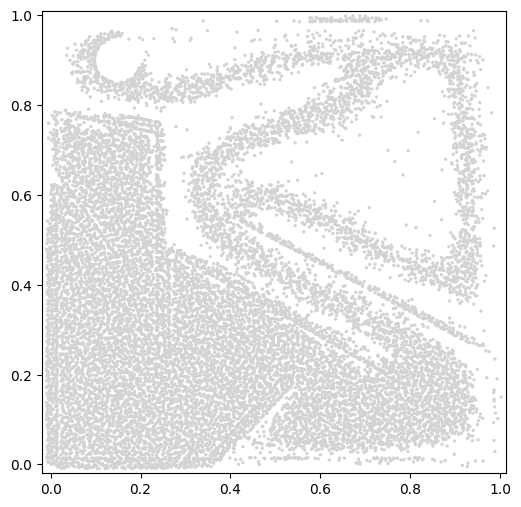

In [13]:
from ribs.visualize import proximity_archive_plot

plt.figure(figsize=(6, 6))
proximity_archive_plot(
    archive,
    ms=2,
    aspect="equal",
    # Since NS does not consider the objective, we make all points have the
    # same color by setting a colormap that has a single color. We also remove
    # the colorbar.
    cmap=["lightgray"],
    cbar=None,
)

In addition to the main archive, we can plot the result archive with [`grid_archive_heatmap`](https://docs.pyribs.org/en/latest/api/ribs.visualize.grid_archive_heatmap.html). This can be useful if we are comparing to other algorithms that use grid archives, such as MAP-Elites.

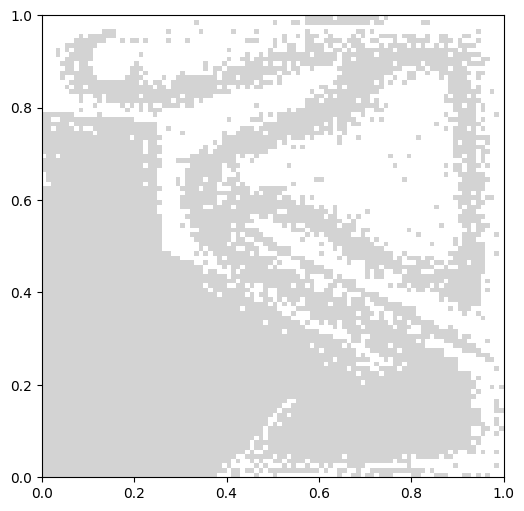

In [14]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(6, 6))
grid_archive_heatmap(
    result_archive,
    cmap=["lightgray"],
    cbar=None,
    aspect="equal",
)

## Visualizing Robot Policies

Besides visualizing the archive, we can visualize some of the robot policies as they navigate the maze. Below we define a function for doing so, adapted from [this example](https://github.com/adaptive-intelligent-robotics/Kheperax/blob/main/examples/rendering/gif.py) in Kheperax.

In [15]:
from pathlib import Path
import imageio
from IPython.display import Image

# The default resolution is (1024, 1024), which takes a while to render.
config_kheperax.resolution = (256, 256)

def render_episode(params, path, random_key):
    # `env` and `_array_to_pytree_fn` were defined when we initialized the
    # Kheperax environment.
    params_pytree = _array_to_pytree_fn(jnp.asarray(params))
    jit_inference_fn = jax.jit(policy_network.apply)
    jit_env_step = jax.jit(env.step)
    
    random_key, subkey = jax.random.split(random_key)
    state = env.reset(subkey)

    rollout = []
    base_image = env.create_image(state)
    
    for step in trange(1 + config_kheperax.episode_length):
        # Take action with the policy. We need this check because we run for an
        # extra step so that the initial state is rendered.
        if step > 0:
            action = jit_inference_fn(params_pytree, state.obs)
            state = jit_env_step(state, action)
        
        # Render the image of the maze.
        image = env.add_robot(base_image, state)
        image = env.add_lasers(image, state)
        image = env.render_rgb_image(image, flip=True)
        rollout.append(image)
        
        if state.done:
            break

    # Make GIF
    fps = 30
    duration = config_kheperax.episode_length / fps
    imageio.mimsave(path, rollout, duration=duration, loop=0)

    return state.info["state_descriptor"]

In [16]:
# Folder for saving animations.
folder = Path("ns_maze_output/")
folder.mkdir(exist_ok=True, parents=True)

First, let us visualize the solution that most closely reaches the target position. In `ProximityArchive`, the `retrieve_single` method retrieves the solution whose measures are closest to the given input measures. Thus, we pass `config_kheperax.target_pos` to `retrieve_single`.

100%|███████████████████████████████████████████████████████████▊| 250/251 [00:15<00:00, 15.81it/s]


Elite Measures: [0.17253622 0.85527873]
Rollout Measures: [0.14153387 0.6689423 ]


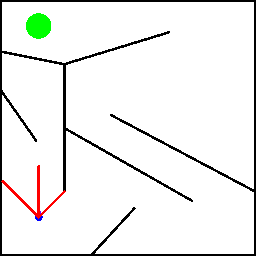

In [17]:
_, elite = archive.retrieve_single(config_kheperax.target_pos)

random_key, subkey = jax.random.split(random_key)
rollout_measures = render_episode(elite["solution"], folder / "kheperax_0.gif", subkey)
print("Elite Measures:", elite["measures"])
print("Rollout Measures:", rollout_measures)
Image(folder / "kheperax_0.gif")

We can also retrieve the solution at another position, such as the bottom right corner `(0.9, 0.1)`.

100%|███████████████████████████████████████████████████████████▊| 250/251 [00:16<00:00, 15.16it/s]


Elite Measures: [0.89985144 0.1009624 ]
Rollout Measures: [0.8679632  0.09037299]


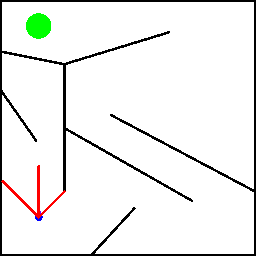

In [18]:
_, elite = archive.retrieve_single([0.9, 0.1])

random_key, subkey = jax.random.split(random_key)
rollout_measures = render_episode(elite["solution"], folder / "kheperax_1.gif", subkey)
print("Elite Measures:", elite["measures"])
print("Rollout Measures:", rollout_measures)
Image(folder / "kheperax_1.gif")

## Conclusion

In this tutorial, we demonstrated how to set up Novelty Search in pyribs and search for diverse policies in the classic deceptive maze environment. Since its introduction in 2011, the maze environment has become one of the most popular benchmarks in the QD community, with plenty of works running their algorithms in it and extending it to other layouts. Meanwhile, Novelty Search has become a foundational work in the field and has inspired a wide array of algorithms. We hope this tutorial serves as a helpful starting point for using pyribs to explore Novelty Search and its role in QD.

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_ns_maze,
  title   = {Exploring Deceptive Mazes with Novelty Search},
  author  = {Bryon Tjanaka},
  journal = {pyribs.org},
  year    = {2025},
  url     = {https://docs.pyribs.org/en/stable/tutorials/ns_maze.html}
}
```